#### Imports

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from scipy.stats import chi2_contingency
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score

In [2]:
warnings.filterwarnings('ignore')

### Loading the data

In [3]:
thyroid_disease_data = pd.read_csv('../final_project/data/Thyroid-Dataset.csv')

In [4]:
thyroid_disease_data.shape

(9171, 23)

In [5]:
pd.set_option('display.max_columns', None)
thyroid_disease_data.head(10)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,class
0,29,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.6,1.9,128.0,NaN,NaN,other,negative
1,41,F,False,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
2,36,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
3,32,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,miscellaneous
4,60,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
5,77,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,other,negative
6,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.7,2.6,116.0,NaN,NaN,SVI,negative
7,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.2,1.8,76.0,NaN,NaN,other,negative
8,28,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.9,1.7,83.0,NaN,NaN,other,negative
9,54,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.9,2.3,133.0,NaN,NaN,other,negative


### Data Exploration

#### Check data types

In [6]:
thyroid_disease_data.dtypes

age                            int64
sex                           object
on thyroxine                    bool
query on thyroxine              bool
on antithyroid medication       bool
sick                            bool
pregnant                        bool
thyroid surgery                 bool
I131 treatment                  bool
query hypothyroid               bool
query hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
hypopituitary                   bool
psych                           bool
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
referral source               object
class                         object
dtype: object

#### Check value counts

In [7]:
def generate_value_counts(data: pd.DataFrame) -> str:
    
    for col in data.columns:
        print(data[col].value_counts())

In [8]:
generate_value_counts(thyroid_disease_data)

age
60       209
62       208
72       207
59       201
61       192
        ... 
3          2
455        1
65511      1
65512      1
65526      1
Name: count, Length: 100, dtype: int64
sex
F    6072
M    2792
Name: count, dtype: int64
on thyroxine
False    7931
True     1240
Name: count, dtype: int64
query on thyroxine
False    9018
True      153
Name: count, dtype: int64
on antithyroid medication
False    9055
True      116
Name: count, dtype: int64
sick
False    8827
True      344
Name: count, dtype: int64
pregnant
False    9064
True      107
Name: count, dtype: int64
thyroid surgery
False    9037
True      134
Name: count, dtype: int64
I131 treatment
False    9002
True      169
Name: count, dtype: int64
query hypothyroid
False    8542
True      629
Name: count, dtype: int64
query hyperthyroid
False    8520
True      651
Name: count, dtype: int64
lithium
False    9078
True       93
Name: count, dtype: int64
goitre
False    9087
True       84
Name: count, dtype: int64
tumor
False    

In [9]:
thyroid_disease_data.loc[thyroid_disease_data.age >= 455]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,class
2975,455,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.10,2.0,118.0,1.13,104.0,SVI,negative
5709,65511,M,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.38,2.0,113.0,1.08,104.0,other,negative
6391,65512,M,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.03,2.8,112.0,0.84,133.0,other,negative
8104,65526,F,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.50,NaN,132.0,1.02,129.0,other,negative


    There are few invalid values in the age column, but the other columns for these records look correct so instead of removing them we might replace them with another value, e.g. average age. 

#### Check for null values

In [10]:
thyroid_disease_data.isnull().sum()

age                             0
sex                           307
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH                           842
T3                           2603
TT4                           441
T4U                           808
FTI                           801
referral source                 0
class                           0
dtype: int64

    We can also check the proportion of numm values

In [11]:
thyroid_disease_data.isnull().mean().round(4)*100

age                           0.00
sex                           3.35
on thyroxine                  0.00
query on thyroxine            0.00
on antithyroid medication     0.00
sick                          0.00
pregnant                      0.00
thyroid surgery               0.00
I131 treatment                0.00
query hypothyroid             0.00
query hyperthyroid            0.00
lithium                       0.00
goitre                        0.00
tumor                         0.00
hypopituitary                 0.00
psych                         0.00
TSH                           9.18
T3                           28.38
TT4                           4.81
T4U                           8.81
FTI                           8.73
referral source               0.00
class                         0.00
dtype: float64

    There are too many missing values in the T3 column, probably will not be used in the analysis, but this decision requires further investigation.

#### Check the distribution of numerical variables

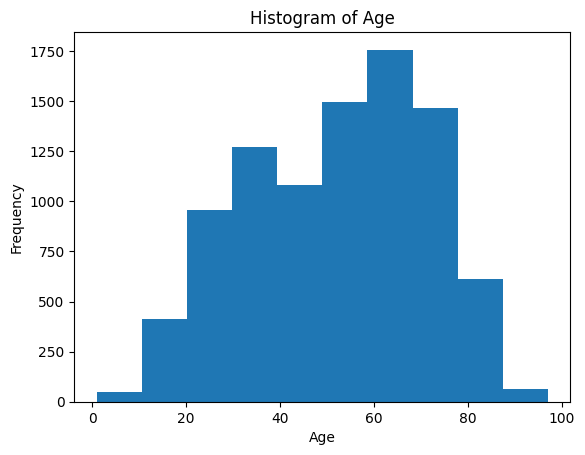

In [12]:
plt.hist(thyroid_disease_data.loc[thyroid_disease_data.age <= 100, 'age'], bins = 10)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age")
plt.show()

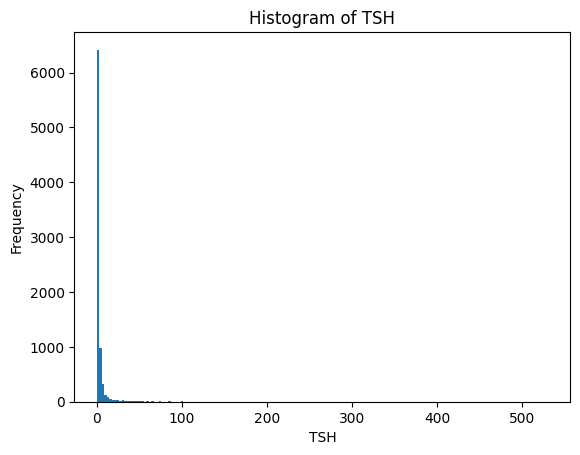

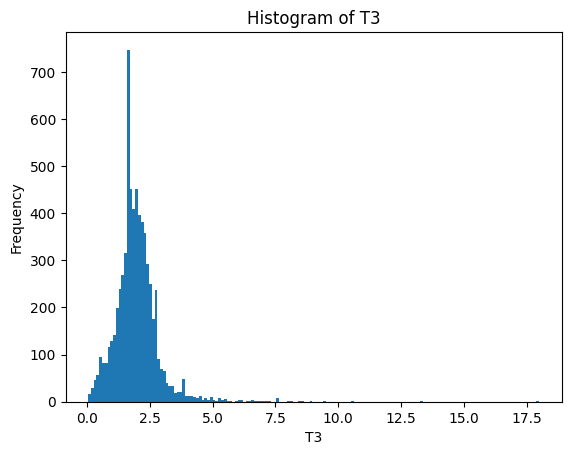

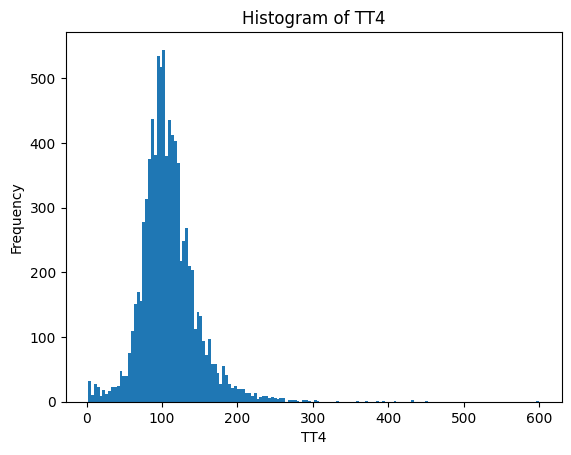

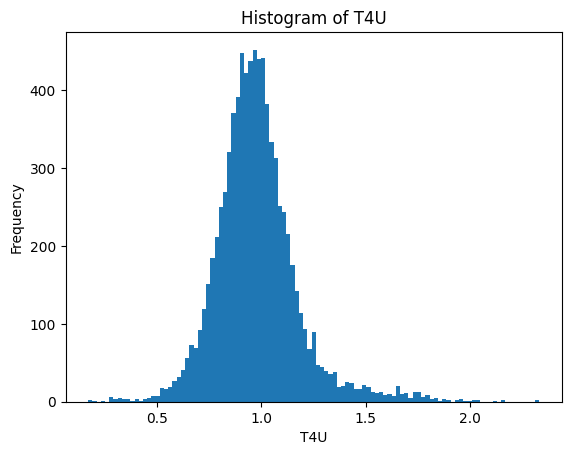

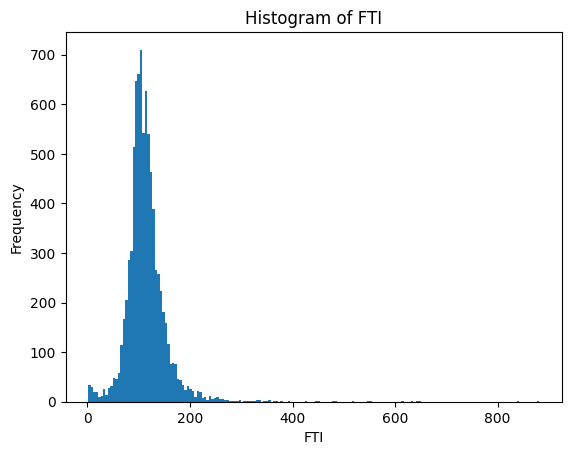

In [13]:
for col in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    plt.hist(thyroid_disease_data[col], bins = 'auto')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

In [14]:
thyroid_disease_data.TSH.describe()

count    8329.000000
mean        5.218993
std        24.185398
min         0.005000
25%         0.460000
50%         1.400000
75%         2.700000
max       530.000000
Name: TSH, dtype: float64

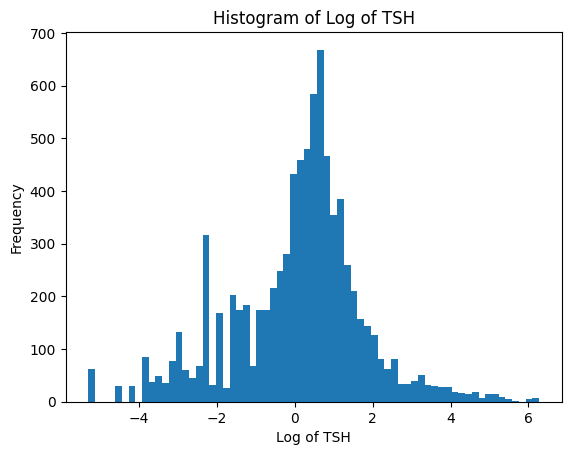

In [15]:
plt.hist(np.log(thyroid_disease_data.TSH), bins = 'auto')
plt.xlabel('Log of TSH')
plt.ylabel('Frequency')
plt.title(f'Histogram of Log of TSH')
plt.show()

#### Check the distribution of the class (target) variable

    We will be intersted in the the presence or absence of hypothyroidism. Hence, we can derive another column from the class column which is 1 if class = hypothyroid conditions and 0 otherwise. Then we are intersted in the distribution of this derived column.

In [16]:
thyroid_disease_data['class'].value_counts(normalize=True)

class
negative                   0.738196
hypothyroid conditions     0.064660
general health             0.061171
binding protein            0.045142
replacement therapy        0.036637
discordant results         0.021481
hyperthyroid conditions    0.019845
miscellaneous              0.009268
antithyroid treatment      0.003598
Name: proportion, dtype: float64

In [17]:
thyroid_disease_data['has_hypothyroidism'] = np.where(thyroid_disease_data['class'] == 'hypothyroid conditions', 1, 0)

In [18]:
thyroid_disease_data['has_hypothyroidism'].value_counts(normalize=True)

has_hypothyroidism
0    0.93534
1    0.06466
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

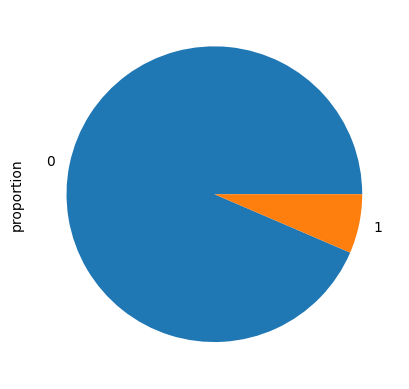

In [19]:
thyroid_disease_data['has_hypothyroidism'].value_counts(normalize=True).plot.pie()

### Data Processing and Cleaning

#### Convert column names to snake case

In [20]:
def convert_to_snake_case(column):
    
    column = column.lower().replace(' ', '_')
    return column


In [21]:
thyroid_disease_data.columns = [convert_to_snake_case(col) for col in thyroid_disease_data.columns]
thyroid_disease_data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'i131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'tsh', 't3', 'tt4', 't4u',
       'fti', 'referral_source', 'class', 'has_hypothyroidism'],
      dtype='object')

In [22]:
thyroid_disease_data.dtypes

age                            int64
sex                           object
on_thyroxine                    bool
query_on_thyroxine              bool
on_antithyroid_medication       bool
sick                            bool
pregnant                        bool
thyroid_surgery                 bool
i131_treatment                  bool
query_hypothyroid               bool
query_hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
hypopituitary                   bool
psych                           bool
tsh                          float64
t3                           float64
tt4                          float64
t4u                          float64
fti                          float64
referral_source               object
class                         object
has_hypothyroidism             int64
dtype: object

#### Convert binary columns to numericsl

In [23]:
bool_cols = thyroid_disease_data.select_dtypes(include = 'bool').columns
thyroid_disease_data[bool_cols] = thyroid_disease_data[bool_cols].astype('int')
thyroid_disease_data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,i131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,tsh,t3,tt4,t4u,fti,referral_source,class,has_hypothyroidism
0,29,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.6,1.9,128.0,NaN,NaN,other,negative,0
1,41,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0
2,36,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0
3,32,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,miscellaneous,0
4,60,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,other,negative,0


In [24]:
thyroid_disease_data['sex'] = np.where(thyroid_disease_data['sex'] == 'F', 1, 0)

In [25]:
generate_value_counts(thyroid_disease_data)

age
60       209
62       208
72       207
59       201
61       192
        ... 
3          2
455        1
65511      1
65512      1
65526      1
Name: count, Length: 100, dtype: int64
sex
1    6072
0    3099
Name: count, dtype: int64
on_thyroxine
0    7931
1    1240
Name: count, dtype: int64
query_on_thyroxine
0    9018
1     153
Name: count, dtype: int64
on_antithyroid_medication
0    9055
1     116
Name: count, dtype: int64
sick
0    8827
1     344
Name: count, dtype: int64
pregnant
0    9064
1     107
Name: count, dtype: int64
thyroid_surgery
0    9037
1     134
Name: count, dtype: int64
i131_treatment
0    9002
1     169
Name: count, dtype: int64
query_hypothyroid
0    8542
1     629
Name: count, dtype: int64
query_hyperthyroid
0    8520
1     651
Name: count, dtype: int64
lithium
0    9078
1      93
Name: count, dtype: int64
goitre
0    9087
1      84
Name: count, dtype: int64
tumor
0    8930
1     241
Name: count, dtype: int64
hypopituitary
0    9169
1       2
Name: count, dtyp

#### Replace wrong Age data with the average Age

In [26]:
thyroid_disease_data.age = np.where(thyroid_disease_data.age > 100, np.mean(thyroid_disease_data.age), thyroid_disease_data.age)

In [27]:
thyroid_disease_data.age.value_counts()

age
60.0    209
62.0    208
72.0    207
59.0    201
61.0    192
       ... 
97.0      3
95.0      3
9.0       2
5.0       2
3.0       2
Name: count, Length: 97, dtype: int64

#### Missing value imputation

    Before chosing a method for missing value imputation, we want to understand if the data is missing at random or there is a pattern. I will start by exploring the relationship between the missing values in the given column and the variable class, which will be subsequently used as a target variable (after some processing).

In [28]:
non_missing = pd.DataFrame(thyroid_disease_data.loc[~thyroid_disease_data.t3.isnull(), 'class'].value_counts(normalize=True))
non_missing

,proportion
class,
negative,0.725030
general health,0.083892
hypothyroid conditions,0.065317
binding protein,0.041565
replacement therapy,0.030451
discordant results,0.026492
hyperthyroid conditions,0.022229
antithyroid treatment,0.005024


In [29]:
missing = pd.DataFrame(thyroid_disease_data.loc[thyroid_disease_data.t3.isnull(), 'class'].value_counts(normalize=True))
missing

,proportion
class,
negative,0.771418
hypothyroid conditions,0.063004
binding protein,0.054168
replacement therapy,0.052247
miscellaneous,0.032655
hyperthyroid conditions,0.013830
discordant results,0.008836
general health,0.003842


In [30]:
combined = pd.merge(non_missing, missing, left_index = True, right_index = True)
combined

,proportion_x,proportion_y
class,,
negative,0.725030,0.771418
general health,0.083892,0.003842
hypothyroid conditions,0.065317,0.063004
binding protein,0.041565,0.054168
replacement therapy,0.030451,0.052247
discordant results,0.026492,0.008836
hyperthyroid conditions,0.022229,0.013830


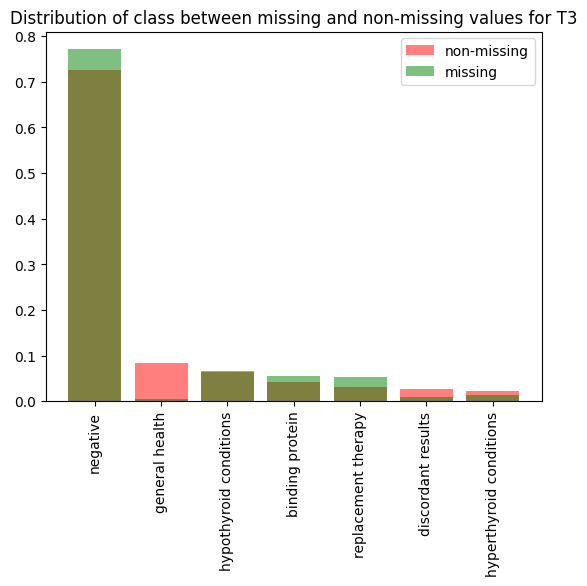

In [31]:
plt.bar(combined.index, combined.proportion_x, alpha = 0.5, color = 'r', label='non-missing')
plt.bar(combined.index, combined.proportion_y, alpha = 0.5, color = 'g', label='missing')
ax = plt.gca()
ax.set_xticklabels(combined.index, rotation=90)
plt.title("Distribution of class between missing and non-missing values for T3")
plt.legend()
plt.show()

    There is a difference between the two distributions, for example there are almost no cases with value 'general health' when the T3 is missing. But we will be interested in predicting hypothyroidism and the relative frequency of hypothyroid condition is the same among observations with missing and non-missing T3. Given that, I assume that it is safe to impute the missing values with the mean. 

    Let's do the same for the other four columns with missing values, namely TSH, TT4, T4U and FTI. 

In [32]:
def check_distribution(col_with_missing_values: str) -> None:
    
    non_missing = pd.DataFrame(thyroid_disease_data.loc[~thyroid_disease_data[col_with_missing_values].isnull(), 'class'].value_counts(normalize=True))
    missing = pd.DataFrame(thyroid_disease_data.loc[thyroid_disease_data[col_with_missing_values].isnull(), 'class'].value_counts(normalize=True))
    combined = pd.merge(non_missing, missing, left_index = True, right_index = True)
    
    plt.bar(combined.index, combined.proportion_x, alpha = 0.5, color = 'r', label='non-missing')
    plt.bar(combined.index, combined.proportion_y, alpha = 0.5, color = 'g', label='missing')
    ax = plt.gca()
    ax.set_xticklabels(combined.index, rotation=90)
    plt.title(f"Distribution of class between missing and non-missing values for {col_with_missing_values.upper()}")
    plt.legend()
    plt.show()

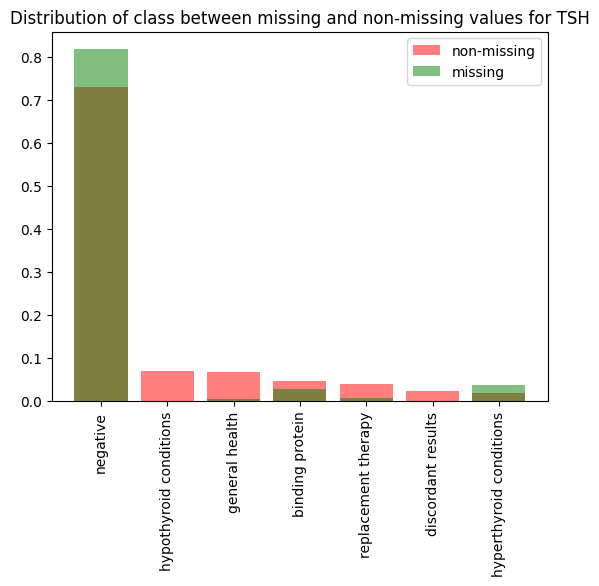

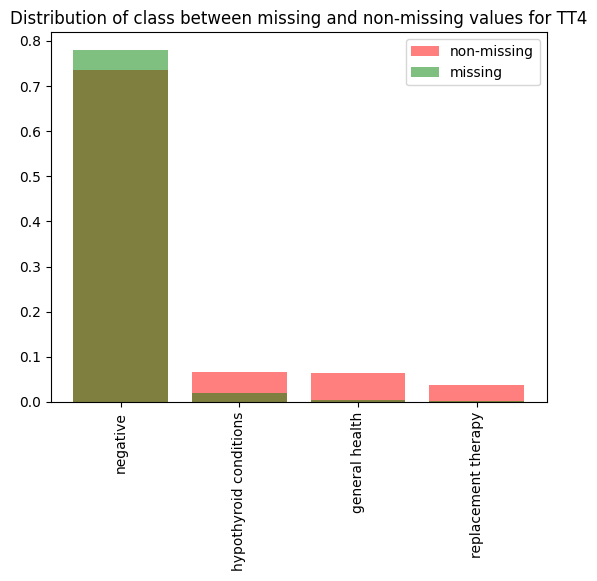

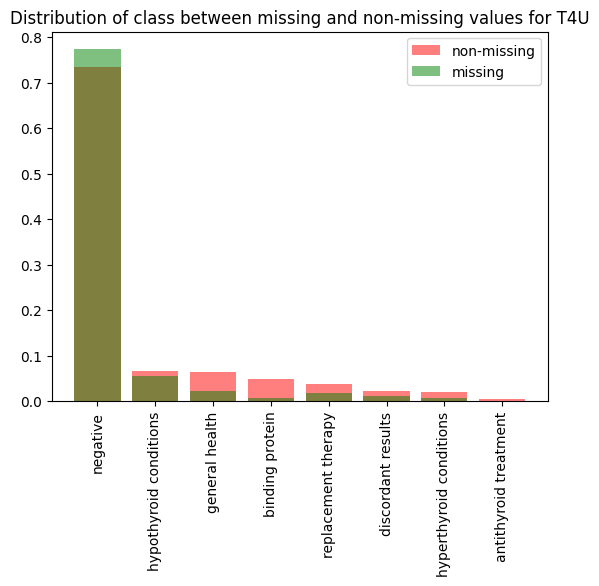

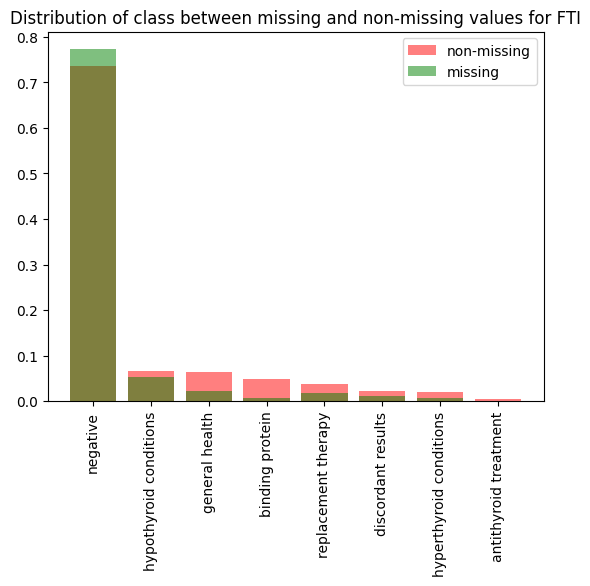

In [33]:
for col in ['tsh', 'tt4', 't4u', 'fti']:
    check_distribution(col)

    The proportion of hypothyroid condition within records with missing and non-missing values for TSH and TT4 is very different which means that replacing them with the average value might lead to decreased model performance. The other options are to either not use these two columns in the machine laerning model or impute them with a value which is different from all other values, so that these records remain in the dataset but also remain different from all other records. Given that the hypothyroid condition exists only for 6% of the records, it might be that records with missing values for TSH and TT4 don't have a hypothyroid condition purely by change, gut we cannot be sure so for now will continue to explore the option that the fact that the values are missing might have a discriminative power.

    At the same time I think that the missing values in the T4U and FTI columns can be replaced with the mean.

#### Perform univariate imputation

In [34]:
def missing_value_imputation(dataset: pd.DataFrame, col_with_missing_value: str, substitue_value: float) -> pd.DataFrame:
    
    dataset[col_with_missing_value] = np.where(dataset[col_with_missing_value].isnull(), substitue_value, dataset[col_with_missing_value])
    return dataset

In [35]:
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 't4u', np.mean(thyroid_disease_data.t4u))
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 'fti', np.mean(thyroid_disease_data.fti))
thyroid_disease_data = missing_value_imputation(thyroid_disease_data, 't3', np.mean(thyroid_disease_data.t3))

In [36]:
thyroid_disease_data[['t4u', 't3', 'fti']].isnull().sum()

t4u    0
t3     0
fti    0
dtype: int64

#### Perform multi-variate imputation

In [37]:
thyroid_disease_data.tsh.describe() # This distribution is highly skewed and probably there are outliers here

count    8329.000000
mean        5.218993
std        24.185398
min         0.005000
25%         0.460000
50%         1.400000
75%         2.700000
max       530.000000
Name: tsh, dtype: float64

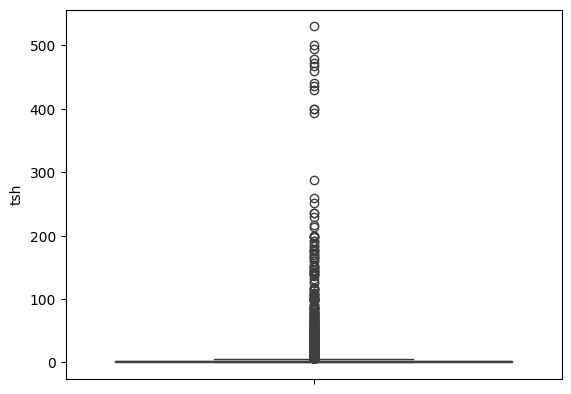

In [38]:
sns.boxplot(thyroid_disease_data.tsh)
plt.show()

In [39]:
thyroid_disease_data.tt4.describe()

count    8730.000000
mean      108.700305
std        37.522670
min         2.000000
25%        87.000000
50%       104.000000
75%       126.000000
max       600.000000
Name: tt4, dtype: float64

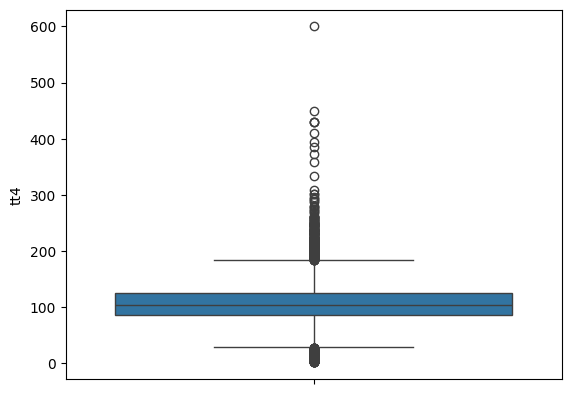

In [40]:
sns.boxplot(thyroid_disease_data.tt4)
plt.show()

    We so far assumed that the missing values in the TSH and TT4 columns migth not be missing at random. To not risk to distort the data by imputing with a mean, or median, or an extreme value, we can use a more sophisticated imputation method, one is not univariate, for example applying a k-nearest neighbour algorithm.

In [41]:
imputer = KNNImputer(n_neighbors=100)

In [42]:
cols = [col for col in thyroid_disease_data.columns if col not in ['referral_source', 'class', 'has_hypothyroidism']]

imputed_data = pd.DataFrame(imputer.fit_transform(
    thyroid_disease_data.loc[:, ~thyroid_disease_data.columns.isin(['referral_source', 'class', 'has_hypothyroidism'])]), 
                           columns=cols)

In [43]:
imputed_data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,i131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,tsh,t3,tt4,t4u,fti
0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.60000,1.900000,128.000,0.976056,113.640746
1,41.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.35525,1.970629,108.680,0.976056,113.640746
2,36.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.25775,1.970629,109.938,0.976056,113.640746
3,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.82595,1.970629,105.733,0.976056,113.640746
4,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.44525,1.970629,107.440,0.976056,113.640746


In [44]:
original_columns = thyroid_disease_data.columns

thyroid_disease_data = pd.merge(
    imputed_data[['tsh', 'tt4']], 
    thyroid_disease_data[[col for col in original_columns if col not in ['tsh', 'tt4']]], 
    left_index=True, 
    right_index=True)

thyroid_disease_data = thyroid_disease_data[original_columns]

### Exploratory Data Analysis

#### Check the relationship between the target and the categorical variables

    We can do this by applying a chi-square test of independence

In [45]:
dataset_categorical = thyroid_disease_data.select_dtypes(include='int')
pairs = list(itertools.combinations(dataset_categorical.columns, 2))
output_df = pd.DataFrame(columns=['first_col', 'second_col', 'chi_square_stat', 'p_value'])

for pair in pairs:
    contingency_table = pd.crosstab(dataset_categorical[pair[0]], dataset_categorical[pair[1]])
    chi2_stat, p_val  = chi2_contingency(contingency_table)[:2]

    if p_val <= 0.1:
        new_row = pd.DataFrame({'first_col': [pair[0]], 'second_col': [pair[1]], 'chi_square_stat': [chi2_stat], 'p_value': [p_val]})
        output_df = pd.concat([output_df, new_row], ignore_index=True)

    output_df = output_df.sort_values(by = ['first_col', 'second_col'])

output_df.loc[(output_df['first_col'] == 'has_hypothyroidism') | (output_df['second_col'] == 'has_hypothyroidism')]

,first_col,second_col,chi_square_stat,p_value
0,goitre,has_hypothyroidism,4.831279,2.794789e-02
11,on_thyroxine,has_hypothyroidism,46.099695,1.123860e-11
18,pregnant,has_hypothyroidism,6.441603,1.114780e-02
51,psych,has_hypothyroidism,14.227687,1.619698e-04
26,query_hypothyroid,has_hypothyroidism,54.214470,1.797583e-13
32,sex,has_hypothyroidism,16.233351,5.599955e-05
43,sick,has_hypothyroidism,2.994153,8.356560e-02


    There are a few variables which show a potentially strong relationship with the target variable. Let's also explore the relationship of the target with the numerical features.

    Let's check the chi-square test statistic for the referral_source 

In [46]:
contingency_table_referral_source = pd.crosstab(
    thyroid_disease_data.referral_source,
    thyroid_disease_data.has_hypothyroidism
)
chi2_stat, p_val  = chi2_contingency(contingency_table)[:2]
chi2_stat, p_val

(np.float64(14.2276870063114), np.float64(0.00016196981565359155))

    The p-value is below our threshold of 10% so it is likely that the referral_source feature has a significant predictive power.

#### Check the relationship between the target and the numerical variables

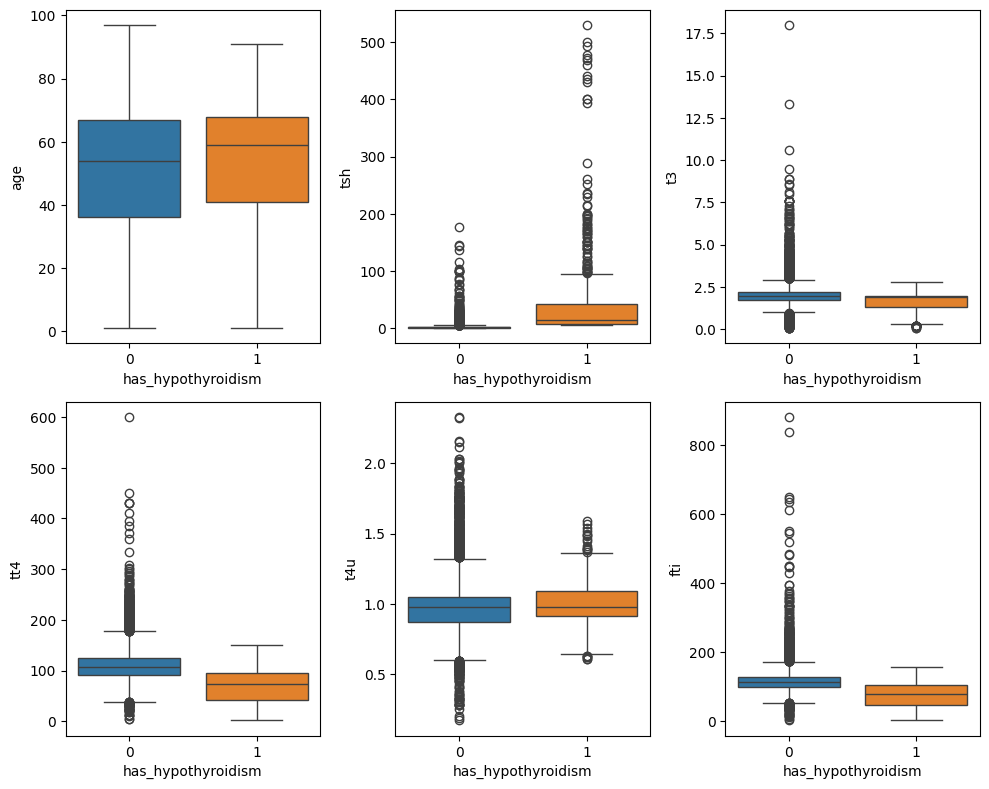

In [47]:
fig= plt.figure(figsize=(10,8))
custom_palette = sns.color_palette()
i = 1

for col in ['age', 'tsh', 't3', 'tt4', 't4u', 'fti']:
    fig.add_subplot(2,3,i)
    sns.boxplot(x=thyroid_disease_data["has_hypothyroidism"], y=thyroid_disease_data[col], palette=custom_palette)
    i+=1

plt.tight_layout()
plt.show()


    Potentially the TSH, T3, TT4 and FTI have a strong relationship with the target variable. Let's explore the correlation as well.

#### Check for multicollinearity

**Multicollinearity between continuous variables**

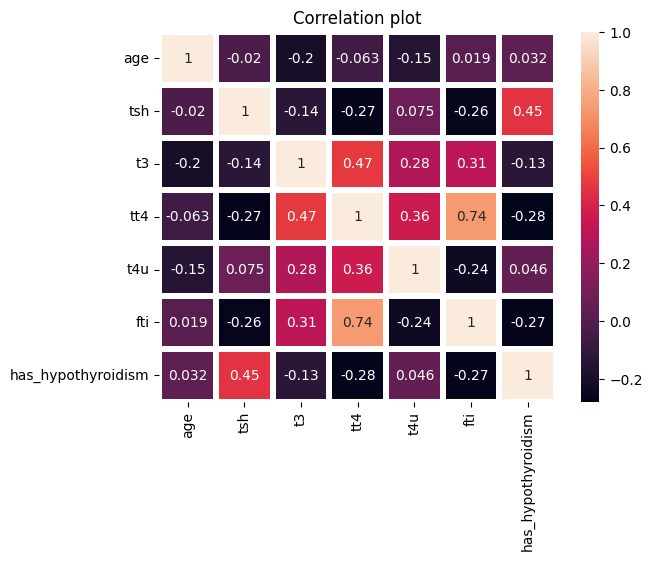

In [81]:
dataset_num = thyroid_disease_data.select_dtypes(include='float')
dataset_num = pd.merge(dataset_num, thyroid_disease_data['has_hypothyroidism'], left_index=True, right_index=True)

corr_plot = sns.heatmap(dataset_num.corr(), annot = True, linewidths=3) # Calculating Pearson correlation
plt.title("Correlation plot")
plt.show()

    We again see that TSH has the biggest linear relationship with the target. But we also see that some of the features are highly correlated, for example T3 and TT4, TT4 and FTI, potentially TT4 and T4U. This means that if we include all of the in the model we will introduce multicollinearity which will deteriorate the model performance on unseen data. This needs to be considered when building the model.

**Multicollinearity between binary categorical variables**

    For this purpose we will use the phi coefficient, or the so called Matthews correlation coefficient (MCC).

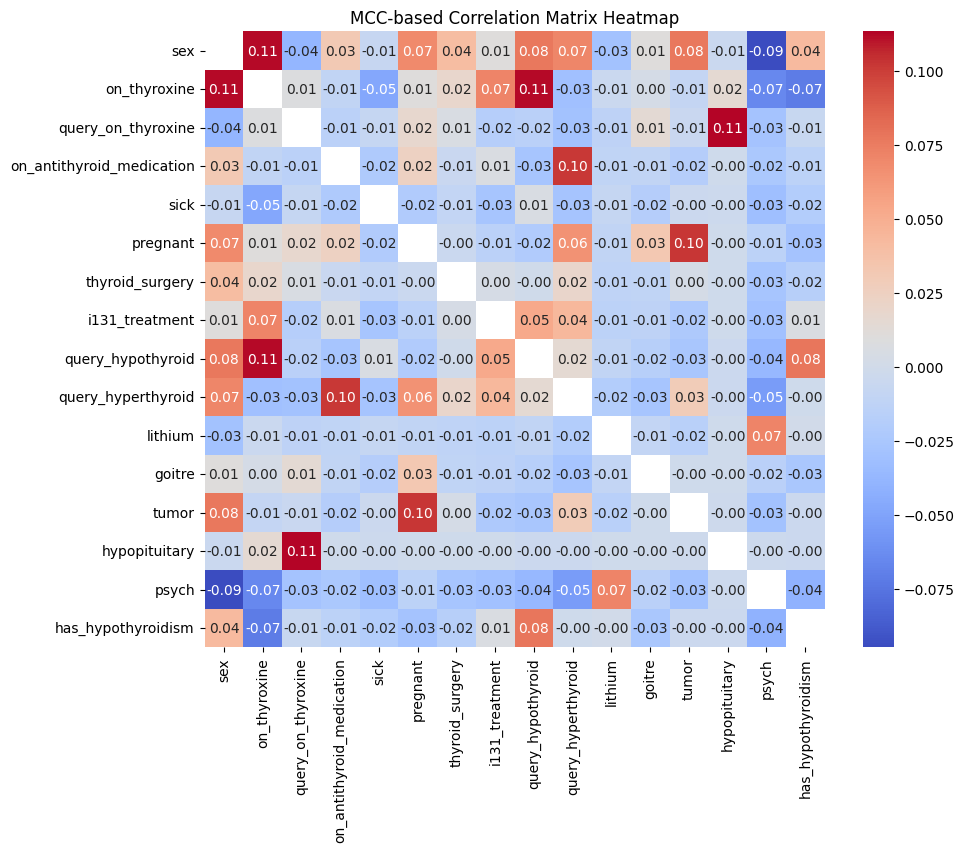

In [86]:
mcc_matrix = pd.DataFrame(index=dataset_categorical.columns, columns=dataset_categorical.columns)

for col1 in dataset_categorical.columns:
    for col2 in dataset_categorical.columns:
        mcc = matthews_corrcoef(dataset_categorical[col1], dataset_categorical[col2])
        mcc_matrix.loc[col1, col2] = mcc

np.fill_diagonal(mcc_matrix.values, np.nan)

plt.figure(figsize=(10, 8))
sns.heatmap(mcc_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('MCC-based Correlation Matrix Heatmap')
plt.show()

### Model Building

In [49]:
modelling_data = thyroid_disease_data.copy()
modelling_data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,i131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,tsh,t3,tt4,t4u,fti,referral_source,class,has_hypothyroidism
0,29.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.60000,1.900000,128.000,0.976056,113.640746,other,negative,0
1,41.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.35525,1.970629,108.680,0.976056,113.640746,other,negative,0
2,36.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.25775,1.970629,109.938,0.976056,113.640746,other,negative,0
3,32.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.82595,1.970629,105.733,0.976056,113.640746,other,miscellaneous,0
4,60.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.44525,1.970629,107.440,0.976056,113.640746,other,negative,0


    We need to exclude the column class from the modelling because the target variable is derived from it and the two will be highly correlated (but this will be a form of leakage instead of a real predictive power).

In [50]:
modelling_data = modelling_data.drop('class', axis=1)

    Split the data into features and target.

In [51]:
y = modelling_data[['has_hypothyroidism']].copy(deep=True)
x = modelling_data.drop('has_hypothyroidism', axis=1)

#### Feature Standardization

    This step is required to improve the ocnvergence of the gradient descent algorithm, because each faeture takes part in the formula for the partial derivative with respect to its coefficient. Hence the feature magnitude will affect the step size and if different features induce different step size the algorithm will converge more slowly or not converge at all.

In [52]:
def standardize_numeric_variables(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes the numeric variables in the DataFrame by subtracting the mean and dividing by the standard deviation.

    Args:
        dataset: The input DataFrame containing numeric variables to be standardized.
    
    Returns:    
        A DataFrame with standardized numeric variables.
    """

    dataset_numeric = dataset.select_dtypes(include = ['int', 'float'])
    
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(dataset_numeric)
    standardized_df = pd.DataFrame(standardized_data, columns=dataset_numeric.columns)
    
    return standardized_df 

In [53]:
x_standardized = standardize_numeric_variables(x)

In [54]:
x_standardized.tt4.mean()
x_standardized.tt4.std()

np.float64(1.0000545241406038)

In [55]:
x_standardized = pd.merge(
    x_standardized,
    x[['referral_source']],
    left_index = True, 
    right_index = True
)

In [56]:
x_standardized.head()
x_standardized.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,i131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,tsh,t3,tt4,t4u,fti,referral_source
9166,0.205629,-1.399765,-0.395409,-0.130254,-0.113184,-0.197412,-0.108651,-0.12177,-0.137017,-0.271360,3.617673,-0.101215,-0.096146,-0.164279,-0.014769,-0.218529,0.082787,-8.869097e-16,-1.221838,-0.763414,-0.923098,SVI
9167,-1.592367,-1.399765,-0.395409,-0.130254,-0.113184,-0.197412,-0.108651,-0.12177,-0.137017,-0.271360,-0.276421,-0.101215,-0.096146,-0.164279,-0.014769,-0.218529,-0.100753,-8.869097e-16,-0.484461,-0.292996,-0.368847,SVI
9168,0.893098,-1.399765,-0.395409,-0.130254,-0.113184,-0.197412,-0.108651,-0.12177,-0.137017,-0.271360,-0.276421,-0.101215,-0.096146,-0.164279,-0.014769,-0.218529,-0.028800,-8.869097e-16,0.116365,1.536407,-0.620779,SVI
9169,-0.270311,0.714406,-0.395409,-0.130254,-0.113184,-0.197412,-0.108651,-0.12177,-0.137017,-0.271360,-0.276421,-0.101215,-0.096146,-0.164279,-0.014769,-0.218529,-0.066759,-8.869097e-16,-0.921425,-0.658876,-0.645972,other
9170,-1.116427,-1.399765,-0.395409,-0.130254,-0.113184,-0.197412,-0.108651,-0.12177,-0.137017,3.685144,-0.276421,-0.101215,-0.096146,-0.164279,-0.014769,-0.218529,0.251414,-8.869097e-16,-1.167218,0.229691,-1.225416,other


#### Apply one-hot encoding of multi-class categorical variables

In [57]:
encoder = OneHotEncoder(sparse_output = False, drop = 'first')
encoded_data = encoder.fit_transform(x_standardized[['referral_source']])
encoded_data

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], shape=(9171, 5))

In [58]:
encoded_df = pd.DataFrame(encoded_data, 
                          columns=encoder.get_feature_names_out(['referral_source']))

x_standardized_encoded = pd.concat(
    [x_standardized.drop('referral_source', axis=1), encoded_df], axis=1
)

#### Dealing with class imbalance

In [59]:
y.has_hypothyroidism.value_counts(normalize=True)

has_hypothyroidism
0    0.93534
1    0.06466
Name: proportion, dtype: float64

In [60]:
y.has_hypothyroidism.value_counts()

has_hypothyroidism
0    8578
1     593
Name: count, dtype: int64

    The minority class is around 6% of the total observations. This is an issue because the model will be biased towards the majority class because if it just predicts all cases to be instances of the negative class, the accuracy will be 94%. In reality we are actually more interested in he minority class so this total accuracy of 94% is in fact 0% within the minority class and does not serves our needs at all.

    To address this we will:
    
    - use F1 score as a performance metric rather than accuracy - this will help us when evaluating our model performance on the test set
    
    - apply class weighing when training the logistic regression model which will result in penalizing the misclassification of the minority class compared to the majority class (this step will happen during the implementation of the logist regression model fitting)

#### Train-Test-Validation Split

In [61]:
x_train, x_rest, y_train, y_rest = train_test_split(x_standardized_encoded, y, random_state = 123, train_size=0.7)

In [62]:
print("train size x : ",x_train.shape)
print("train size y : ",y_train.shape)
print("rest size x : ",x_rest.shape)
print("rest size y : ",y_rest.shape)

train size x :  (6419, 26)
train size y :  (6419, 1)
rest size x :  (2752, 26)
rest size y :  (2752, 1)


In [63]:
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, random_state = 123, train_size=0.5)

In [64]:
print("test size x : ",x_test.shape)
print("test size y : ",y_test.shape)
print("validation size x : ",x_val.shape)
print("validation size y : ",y_val.shape)

test size x :  (1376, 26)
test size y :  (1376, 1)
validation size x :  (1376, 26)
validation size y :  (1376, 1)


    Making sure that we have enough instances of the positive class in the test and validation sets to be able to derive statistically significant conclusions.

In [65]:
y_test.value_counts()

has_hypothyroidism
0                     1289
1                       87
Name: count, dtype: int64

In [66]:
y_val.value_counts()

has_hypothyroidism
0                     1288
1                       88
Name: count, dtype: int64

### Model fitting 

#### Building a baseline model

In [67]:
logistic_regression_base_model = LogisticRegression(penalty = None)

In [68]:
logistic_regression_base_model.fit(x_train,y_train)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**Evaluate model performance of baseline model**

    As stated above, we will evaluate the model performance using the F1 score, but will also calculate the area under the ROC curve.

    F1 Score = 2*(Recall * Precision) / (Recall + Precision), where 

    - Precision = TP/TP+FP
    - Recall = Recall = TP/TP+FN

In [69]:
def evaluate_model_performance(model, x_data, y_data):
    
    """
    The function takes a trained logistic regression model and applies it on the test set, 
    after which the model performance is evaluated based on F1 score and ROC-AUC.

    Args:
        model (sklearn.linear_model._logistic.LogisticRegression): a trained logistic regression model
        x_data (pd.DataFrame): a data frame with the feature values
        y_data (pd.DataFrame): a data frame with the values of the target variable corresponding to the x_data

    Returns:
        - confusion matrix
        - precision
        - recall
        - ROC-AUC
        - F1
    """
    
    # Calculate the probability of the sample to belong to the positive class
    y_predicted_prob = model.predict_proba(x_data)[:, 1] 
    
    # Calculate the predicted labels on the test set (0.5 prob threshold used)
    y_predicted = model.predict(x_data)
    
    # create onfusion matrix
    cm = confusion_matrix(np.array(y_data), y_predicted)
    index = ['actual no hypothyroidism', 'actual hypothyroidism']
    columns = ['pred no hypothyroidism', 'pred hypothyroidism']
    cm_df = pd.DataFrame(cm, index = index, columns = columns)
    print('Confusion matrix')
    print(cm_df)
    print()
    
    # ROC- AUC score
    roc = roc_auc_score(y_data,y_predicted_prob)
    print(f'ROC-AUC score test dataset: {roc:.2f}')
    print()
    
    # Precision score
    precision = precision_score(y_data, y_predicted)
    print(f'precision score  test dataset: {precision:.2f}')
    print()
    
    # Recall Score
    recall = recall_score(y_data, y_predicted)
    print(f'Recall score  test dataset: {recall:.2f}')
    
    # F1 score
    f1_score_stat = f1_score(y_data,y_predicted)
    print(f'f1 score for base model is : {f1_score_stat:.2f}')


In [70]:
evaluate_model_performance(logistic_regression_base_model, x_test, y_test)

Confusion matrix
                          pred no hypothyroidism  pred hypothyroidism
actual no hypothyroidism                    1283                    6
actual hypothyroidism                         44                   43

ROC-AUC score test dataset: 0.96

precision score  test dataset: 0.88

Recall score  test dataset: 0.49
f1 score for base model is : 0.63


#### Building a model with balanced classes

In [71]:
logistic_regression_balanced = LogisticRegression(class_weight = 'balanced', penalty = None)
logistic_regression_balanced.fit(x_train,y_train)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**Evaluate the model performence on test data**

In [72]:
evaluate_model_performance(logistic_regression_balanced, x_test, y_test)

Confusion matrix
                          pred no hypothyroidism  pred hypothyroidism
actual no hypothyroidism                    1248                   41
actual hypothyroidism                          3                   84

ROC-AUC score test dataset: 0.98

precision score  test dataset: 0.67

Recall score  test dataset: 0.97
f1 score for base model is : 0.79


    We see a significant performance improvement when we applied class weights which in essense apply a penalty on misclassifying the minority class.

#### Building a Ridge Regression on balanced data

In [73]:
ridge_regression_balanced = LogisticRegression(class_weight = 'balanced', penalty = 'l2')
ridge_regression_balanced.fit(x_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**Evaluate the model performance on test data**

In [74]:
evaluate_model_performance(ridge_regression_balanced, x_test, y_test)

Confusion matrix
                          pred no hypothyroidism  pred hypothyroidism
actual no hypothyroidism                    1249                   40
actual hypothyroidism                          3                   84

ROC-AUC score test dataset: 0.98

precision score  test dataset: 0.68

Recall score  test dataset: 0.97
f1 score for base model is : 0.80


    Here we don't see any material performance improvement over the previous model. This might be due to the fact that the regularization strength is not optimal or that there is no multicollinearity to be addressed with regularization.

### Expected model performance on unseen data

    Now that we have built three logistic regression models on the training data and evaluated their performance on the test data, we can choose the best one based on the test set result and apply it on the validation data. The performance on the validation data is what we can expect from the model when applied to future (and unseen) data. 

**Note:** The performance on the test data is not a good estimation of how the model will perform in the future because we use the performance on the test data as a criteria for choosing the best model. I.e., the test data is not unseen data for the model. The valiadtion data on the other hand is truly an unseen data, hence is the best approxiamtion of the model's future performance is there is no shift in the past trends.

    We can choose either of the second (balanced with no regularization) and third (balanced with regularization) models because they perform equally well on the test data. Given that the third is more complex than the second though, we will go with the second.

**Evaluate model performance on validation data**

In [75]:
evaluate_model_performance(logistic_regression_balanced, x_val, y_val)

Confusion matrix
                          pred no hypothyroidism  pred hypothyroidism
actual no hypothyroidism                    1250                   38
actual hypothyroidism                          7                   81

ROC-AUC score test dataset: 0.98

precision score  test dataset: 0.68

Recall score  test dataset: 0.92
f1 score for base model is : 0.78


    Happily there is only a very slight drop in the F1 score, from 0.79 to 0.78, between the test and validation set and some drop is expected given that the validation set is completely external for the model.

### Interpret model results

In [76]:
from scipy.stats import norm

In [77]:
coefficients = logistic_regression_balanced.coef_[0]
intercept = logistic_regression_balanced.intercept_[0]

# Calculate standard errors of coefficients
n = len(y_train)
p = x_train.columns # These are the featues
std_errors = np.sqrt(np.diag(np.linalg.inv(x_train.T @ x_train)))

# Calculate z-scores and p-values for each coefficient
z_scores = coefficients / std_errors
p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_scores]

# Create a DataFrame of features, coefficients, and p-values
df_summary = pd.DataFrame({
    'feature': p,
    'coefficient': coefficients,
    'z_score': z_scores,
    'p_value': p_values,
    'std': std_errors
})

df_summary_sorted = df_summary.reindex(df_summary['coefficient'].abs().sort_values(ascending=False).index).reset_index(drop=True)
df_summary_sorted

,feature,coefficient,z_score,p_value,std
0,tsh,13.993466,927.762447,0.000000e+00,0.015083
1,on_thyroxine,-4.695184,-346.421460,0.000000e+00,0.013553
2,goitre,-3.100538,-247.588901,0.000000e+00,0.012523
3,pregnant,-2.019384,-151.192242,0.000000e+00,0.013356
4,thyroid_surgery,-1.372527,-113.609825,0.000000e+00,0.012081
5,referral_source_SVHC,-0.629991,-13.050686,0.000000e+00,0.048273
6,hypopituitary,-0.603532,-57.187291,0.000000e+00,0.010554
7,referral_source_SVI,-0.530866,-20.089229,0.000000e+00,0.026425
8,referral_source_SVHD,-0.389557,-2.814055,4.892080e-03,0.138433
9,fti,-0.343780,-10.391709,0.000000e+00,0.033082


    Keep only features with p_value below 1%

In [78]:
df_summary_sorted.loc[df_summary_sorted.p_value <= 0.01].reset_index(drop=True)

,feature,coefficient,z_score,p_value,std
0,tsh,13.993466,927.762447,0.000000e+00,0.015083
1,on_thyroxine,-4.695184,-346.421460,0.000000e+00,0.013553
2,goitre,-3.100538,-247.588901,0.000000e+00,0.012523
3,pregnant,-2.019384,-151.192242,0.000000e+00,0.013356
4,thyroid_surgery,-1.372527,-113.609825,0.000000e+00,0.012081
5,referral_source_SVHC,-0.629991,-13.050686,0.000000e+00,0.048273
6,hypopituitary,-0.603532,-57.187291,0.000000e+00,0.010554
7,referral_source_SVI,-0.530866,-20.089229,0.000000e+00,0.026425
8,referral_source_SVHD,-0.389557,-2.814055,4.892080e-03,0.138433
9,fti,-0.343780,-10.391709,0.000000e+00,0.033082


    We can use the absolute value of the coefficients as a measure of feature importance. In our case, the TSH has the biggest predictive power with regards to whether someone has hypothyroidism, whether the patient currently takes thyroxine is the second and so on. The sign of the coefficient indicates the direction of the relationship between the featue and the target. For example, higher values of TSH indicate higher probability that the person has hypothyroidism. While this is more intuitive for continuous variables, it is not that straightforward for binary variables, which are either categorical variables with two possible values on multi-variate categorical variables which where one-hot encoding wad applied.

    Let's take the variable sex, which coefficient is 0.13. The values for sex are either 0, which represents Male or 1, which is Female. As with every other variable, the model coefficient tells us by how much the log (odds) change if we change the feature value by 1, and keep all other features the same. In case of binary variable, this same thing means that the log of odds change with 0.13 if you are a woman, compared to if you are a man. I.e., women are more likely to develop hypothyroidism than men.

    What I find interesting is the negative relationship between the psych variable and hypothyroidism. As per my knowledge (based on research), hypothyroidism can cause depression, ot put it differently, depression is one of the possible symptoms of hypothyroidism. I will try to evaluate this relationship using another, completely independent data source.

**Note:** Because the interpretation of the coefficients is change in log odds by 1 unit change in the variable of interest **keeping all other variables constant**, it might be possible effect of the variable psych on hypothyroidism is being alredy represented in the coefficient of another variable which is highly correlated with the psych variable. This together with a high standard deviation might result in the coefficient being zero (or close to zero) and with a sign which is opposite of the actual relationship that the variable has with the target. But looking at the standard deviation of the psych variable, its very small compared to the model coefficient, hence it is unlikely that the relationship is inversed because ot this.